# Proyecto K-nearest neihbours

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import HalvingGridSearchCV

In [172]:
wine_data = pd.read_csv("../data/raw/08_winequality-red.csv", sep=';')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [173]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


El dataset no tiene nulos, a continuación vamos a comprobar la distribución de la variable objetivo (quality)

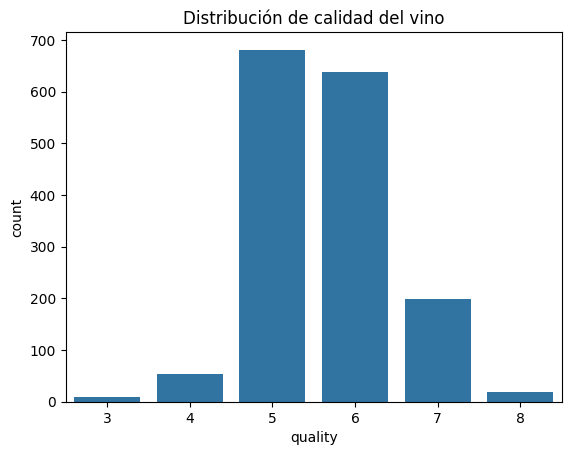

In [174]:
sns.countplot(x=wine_data["quality"])
plt.title("Distribución de calidad del vino")
plt.show()

Distribución de todas las variables númericas del dataset

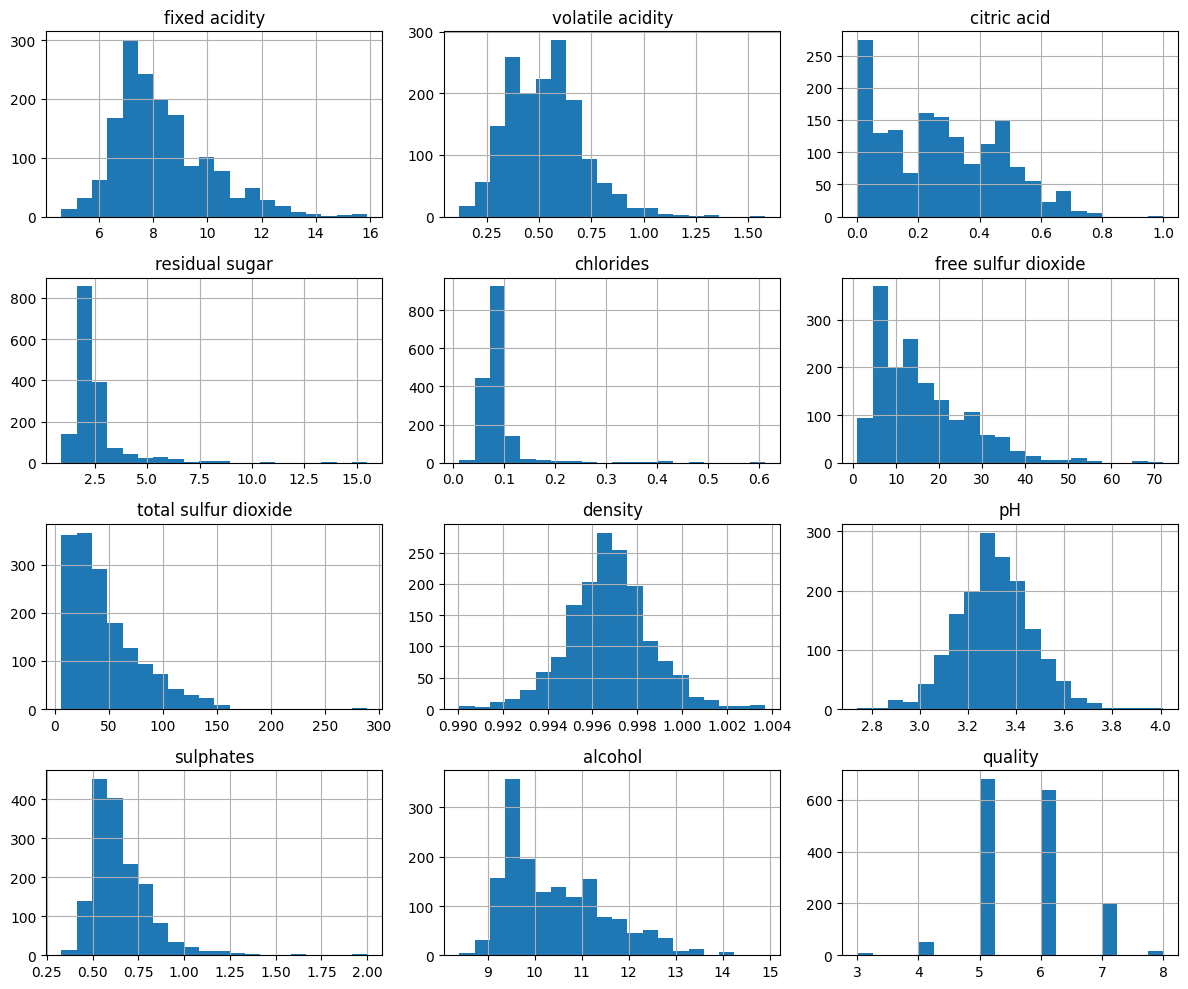

In [175]:
wine_data.hist(bins=20, figsize=(12, 10))
plt.tight_layout()
plt.show()

Correlacion, no carrelaciono antes de categorizar quality

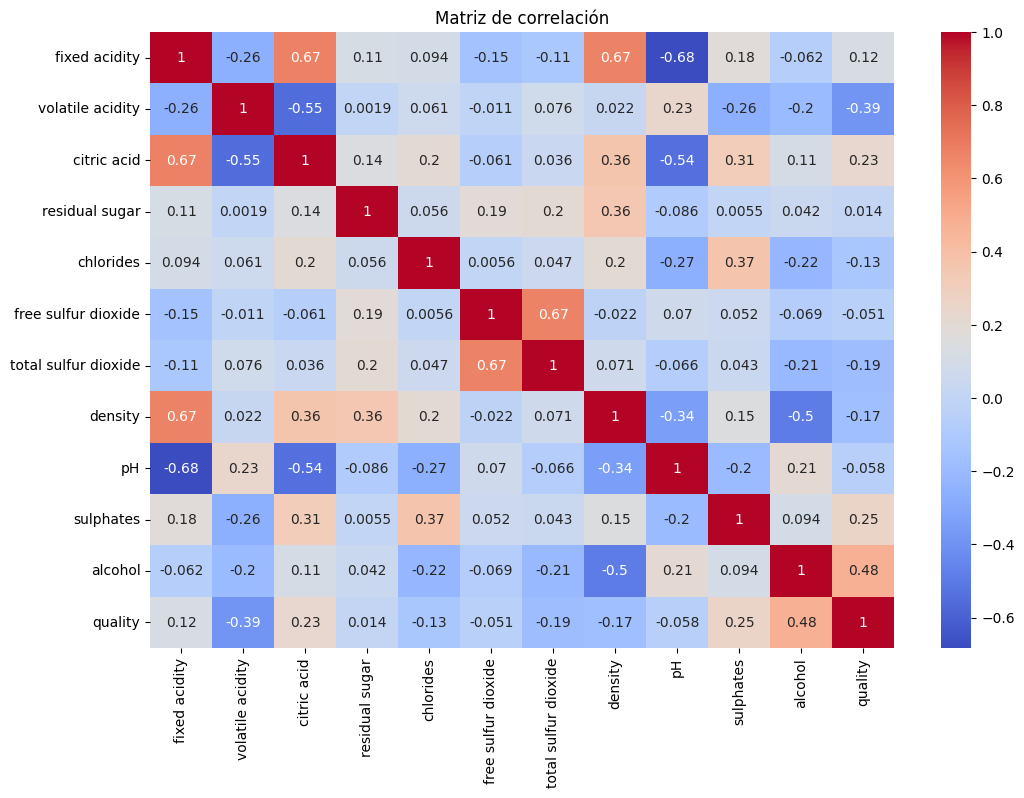

In [176]:
plt.figure(figsize=(12,8))
sns.heatmap(wine_data.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

La matriz de correelación se ha calculado antes de categorizar la variable quality ya que esta variable es continua y nos permite medir realciones lineales entre variables. Las correlaciones nos muestran que la calidad del vino se asocia positivamente con alcohol (0,48), sulfatos(0,25), y acido citrico (0,23); y negativamente con acidez volatil (0,39). Estas variables predictoras serán las mas influyentes en nuestro modelo. 

Categorización de quality

In [177]:
def cat_quality(qlt):
    if qlt <= 4:
        return 1
    elif qlt <= 6:
        return 2
    else:
        return 3

wine_data["label"] = wine_data["quality"].apply(cat_quality)
    
#comprobar que se creo correctamente
wine_data[["quality", "label"]].head()

,quality,label
0,5,2
1,5,2
2,5,2
3,6,2
4,5,2


Volvemos a comprobar la distribución, pero esta vez con la variable label 

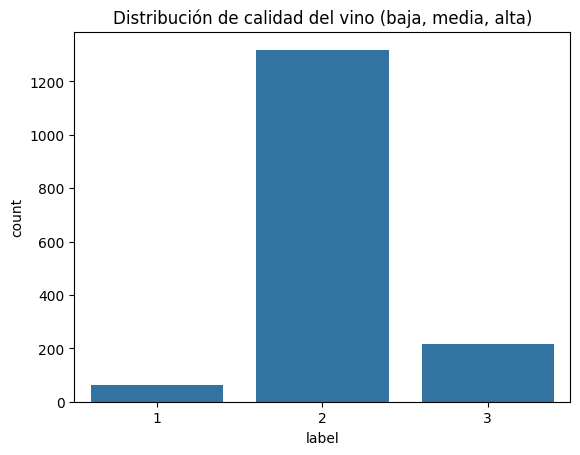

label
2    0.824891
3    0.135710
1    0.039400
Name: proportion, dtype: float64

In [178]:
sns.countplot(x=wine_data["label"])
plt.title("Distribución de calidad del vino (baja, media, alta)")
plt.show()

wine_data["label"].value_counts(normalize=True)


Se ha creado la variable categorica label a partir de quality, agrupando los valores  en baja 1, media 2 y alta 3. Esta transformación es necesaria para convertir la puntuación numérica de quality en un objetivo adecuado para KNN facilitando así  la interpretación del modelo.
Podemos comprobar que el dataset esta desbalanceado, lo cual probablemente afectará al modelo.

### Boxplots por clase

In [179]:
var_predict = wine_data.columns.drop(["quality", "label"])
var_predict

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

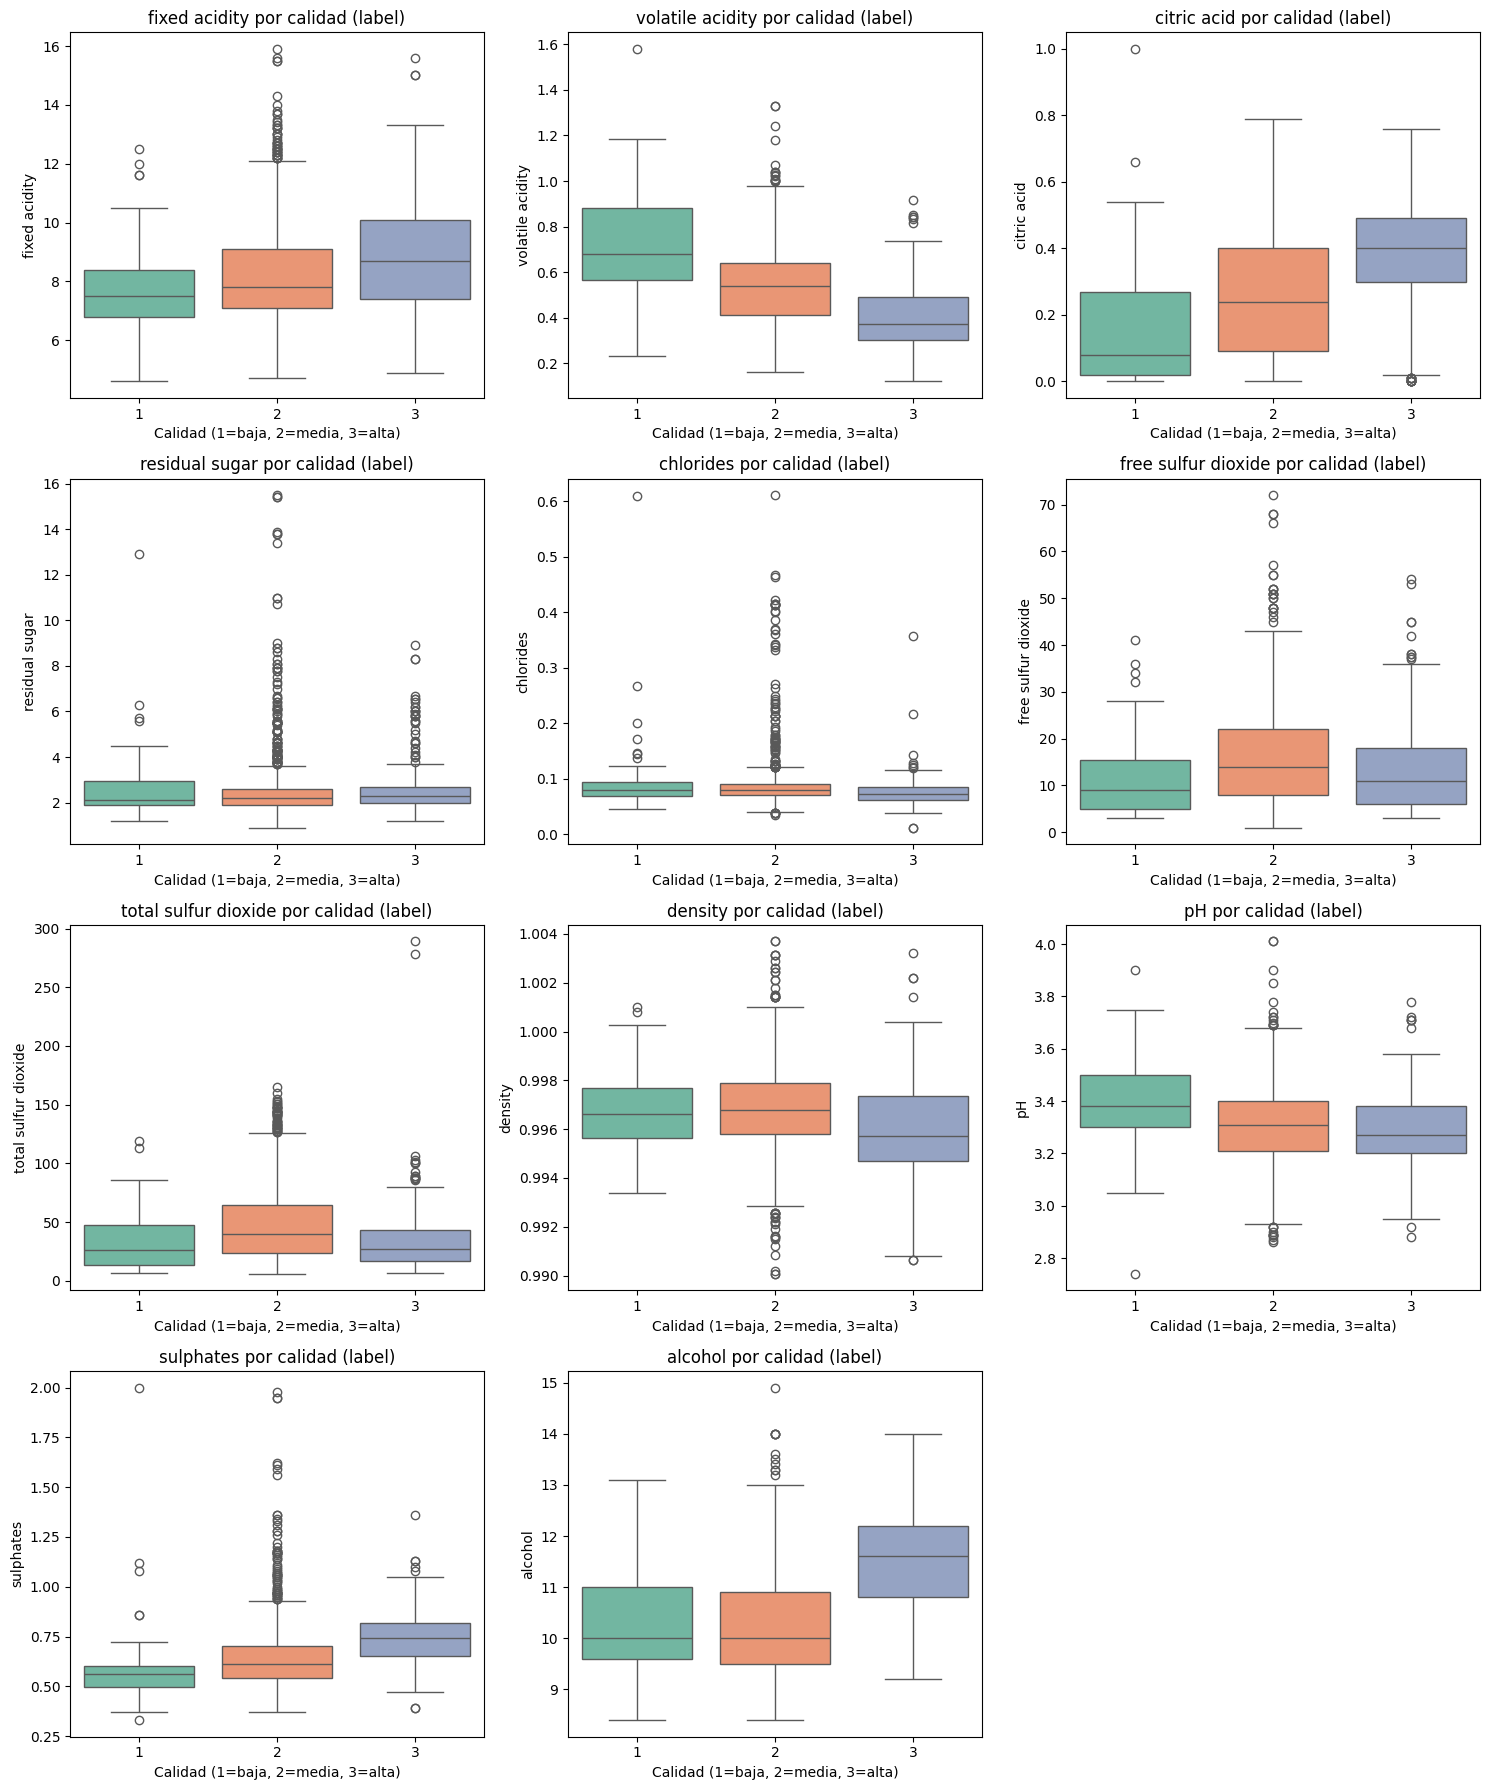

In [180]:
plt.figure(figsize=(15, 18))

for i, col in enumerate(var_predict, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x="label", y=col, data=wine_data, hue="label", palette="Set2", legend=False)
    plt.title(f"{col} por calidad (label)")
    plt.xlabel("Calidad (1=baja, 2=media, 3=alta)")
    plt.tight_layout()
plt.show()

En los boxplots podemos ver que volatile acidity, alcohol, acid citric y sulphates mantienen una tendencia creciente con la calidad, mientras que density es a la inversa, en el resto de variables encontramos solapamiento entre las calidades lo cual no nos aporta información. Vamos a seleccionar estas variables para entrenar el modelo KNN.

In [181]:
selected_features = ["volatile acidity","alcohol", "citric acid", "sulphates", "density"]
X = wine_data[selected_features]
y = wine_data["label"]

Gráfico 3D

In [182]:
fig = px.scatter_3d(wine_data,
                    x="alcohol",
                    y="volatile acidity",
                    z="sulphates",
                    color="label",
                    color_discrete_sequence=px.colors.qualitative.Vivid,
                    title="Distribución 3D de vinos por calidad (label)",
                    width=650,
                    height=600 )
fig.update_traces(marker=dict(size=4))
fig.show()

##### Tain, test y escalado

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)#mantener proporciones dataset original

#Escalado
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### KNN inicial con K = 5 y rendimiento

In [184]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

accuracy_score(y_test, y_pred)

0.8375

In [185]:
confusion_matrix(y_test, y_pred)

array([[  0,  13,   0],
       [  3, 248,  13],
       [  0,  23,  20]])

In [186]:
inf_rep = classification_report(y_test, y_pred, output_dict=True)
df_inf_rep = pd.DataFrame(inf_rep).transpose()
df_inf_rep

,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,13.0000
2,0.873239,0.939394,0.905109,264.0000
3,0.606061,0.465116,0.526316,43.0000
accuracy,0.837500,0.837500,0.837500,0.8375
macro avg,0.493100,0.468170,0.477142,320.0000
weighted avg,0.801862,0.837500,0.817439,320.0000


##### KNN con valores de 1 a 20

In [187]:
k_values = range(1, 21)
accu = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred_k= model.predict(X_test_scaled)
    acc= accuracy_score(y_test, y_pred_k)
    accu.append(acc)

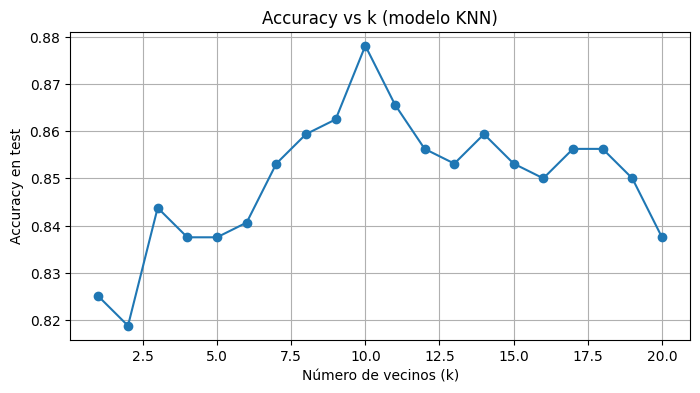

In [188]:
plt.figure(figsize=(8, 4))
plt.plot(k_values, accu, marker="o")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Accuracy en test")
plt.title("Accuracy vs k (modelo KNN)")
plt.grid(True)
plt.show()

In [189]:
best_k_simple = k_values[int(np.argmax(accu))]
best_k_simple, max(accu)

(10, 0.878125)

#### Interpretación

Despues de analizar los resultados se puede ver que aumentar K mejora la accuracy hasta llegar a 87% en K=10 pero en la matriz de confusión podemos ver que el modelo solo funciona bien en la clase mayoritaria, laa 2. La 1 y la 3 presentan un rendimiento muy bajo, esto debe ser por el desbalanceo del dataset ya que la clase 2 es predominante y por la naturaleza de KNN, que depende de la densidad de vecinos. Se deberían probar probar otras técnicas u otros modelos.  
 Vamos a ver si podemos optimizar el modelo con lo que tenemos, usaremos `HalvingGridSearchCV`para ello. `HalvingGridSearchCV` comienza usando muchas combinaciones con menos recursos y en iteraciones sucesivas va descartando los peores modelos y concentrando el cómputo en las mejores configuraciones.

In [190]:
param = {"n_neighbors": list(range(1, 31)), #k de 1 a 30
         "weights": ["uniform", "distance"], #uniform=todos los vecinos pesan igual, distance=los vecinos cercanos pesan mas 
         "metric": ["euclidean", "manhattan"]} # forma de medir distancias entre vecinos

knn_base = KNeighborsClassifier()

halving = HalvingGridSearchCV(estimator=knn_base,
                              param_grid=param,
                              factor=2,# cada iteración se queda con ~1/2 de los mejores
                              scoring="accuracy", #probar con "f1_macro" para este dataset
                              cv=5,
                              verbose=1) #control de la cantidad de mensajes que se muesrtran durante la busqueda de hiperparámetros  

halving.fit(X_train_scaled, y_train)

halving.best_params_
         

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 30
max_resources_: 1279
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 120
n_resources: 30
Fitting 5 folds for each of 120 candidates, totalling 600 fits


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:953: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/vscode/.local/lib/python3.11/site-packages/sklearn/met

----------
iter: 1
n_candidates: 60
n_resources: 60
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.76       0.76       0.72666667 0.76       0.78666667 0.75333333
 0.76       0.78666667 0.72       0.72       0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.72       0.76       0.72       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76              nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.76       0.76       0.72666667 0.76       0.78666667 0.78666667
 0.72666667 0.75333333 0.75333333 0.75333333 0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.

----------
iter: 2
n_candidates: 30
n_resources: 120
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.76       0.76       0.72666667 0.76       0.78666667 0.75333333
 0.76       0.78666667 0.72       0.72       0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.72       0.76       0.72       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76              nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.76       0.76       0.72666667 0.76       0.78666667 0.78666667
 0.72666667 0.75333333 0.75333333 0.75333333 0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.

----------
iter: 3
n_candidates: 15
n_resources: 240
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.76       0.76       0.72666667 0.76       0.78666667 0.75333333
 0.76       0.78666667 0.72       0.72       0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.72       0.76       0.72       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76              nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.76       0.76       0.72666667 0.76       0.78666667 0.78666667
 0.72666667 0.75333333 0.75333333 0.75333333 0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.

----------
iter: 4
n_candidates: 8
n_resources: 480
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 5
n_candidates: 4
n_resources: 960
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.76       0.76       0.72666667 0.76       0.78666667 0.75333333
 0.76       0.78666667 0.72       0.72       0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.72       0.76       0.72       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.76       0.76       0.76              nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.76       0.76       0.72666667 0.76       0.78666667 0.78666667
 0.72666667 0.75333333 0.75333333 0.75333333 0.72       0.75333333
 0.76       0.76       0.76       0.76       0.76       0.76
 0.76       0.

{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}

In [191]:
halving.best_score_

np.float64(0.8550610820244329)

#### Evaluar el modelo en test

In [192]:
best_knn = halving.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)

accuracy_score(y_test,y_pred_best)

0.88125

In [193]:
confusion_matrix(y_test,y_pred_best)

array([[  0,  13,   0],
       [  1, 257,   6],
       [  0,  18,  25]])

In [194]:
inf_rep = classification_report(y_test, y_pred_best, output_dict=True)
df_inf_rep = pd.DataFrame(inf_rep).transpose()
df_inf_rep

,precision,recall,f1-score,support
1,0.000000,0.000000,0.000000,13.00000
2,0.892361,0.973485,0.931159,264.00000
3,0.806452,0.581395,0.675676,43.00000
accuracy,0.881250,0.881250,0.881250,0.88125
macro avg,0.566271,0.518293,0.535612,320.00000
weighted avg,0.844565,0.881250,0.859000,320.00000


### Conclusión

El modelo optimizado a alcanzado su mejor rendimiento mediante `HalvingGridSearchCV` con n_neighbors=23, metric="manhattan" y weights="distance", pero sigue manteniendose el desbalanceo entre las calidades, la clase 1 continua sin ser identificada, por otra parte identifica mejor la clase 3. De todas formas el modelo ofrece un rendimiento razonable con las variables escogidas lo que indica futuras mejoras en el tratamiento del desbalanceo o probar diferentes modelos.